### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pickle 
import torch as th
import torch.nn.functional as F
import torch
import networkx as nx
import pandas as pd
import numpy as np
import dgl 

import torch_geometric
from torch_geometric.explain import Explainer, CaptumExplainer, DummyExplainer, GNNExplainer
from torch_geometric.explain.metric import *
from torch_geometric.nn.models.basic_gnn import GraphSAGE
from torch_geometric.utils import from_dgl
from tqdm import tqdm
from torch_geometric.explain import ModelConfig
import scienceplots

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('../../interm/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
    
def view_metrics(metrics_list, legend=None, s=3):
    for i, metrics in enumerate(metrics_list):
        if legend:
            print(f'\n{legend[i]}')
        
        fp, fn = metrics['softmask fidelity']
        print(f'fid+ : {fp:.4f}\tfid- : {fn:.4f}\n')
        print(f"{'Class':<15}{'fid+':>10}{'fid-':>10}{'char':>10}")
        for attack in encoders['Attack'].classes_:
            fp, fn, c = metrics[f'softmask fidelity {attack}']
            print(f"{attack:<15}{fp:>10.3f}{fn:>10.3f}{c:>10.3f}")
    
    # plt.style.use(['science','no-latex'])
    with plt.style.context('science'): 
           
        for metrics in metrics_list:
            plt.plot(metrics['s'], metrics['fid-'])
            plt.scatter(metrics['s'], metrics['fid-'], s=s)
        
        plt.title('Sparsity Vs Fidelity-')
        if legend: plt.legend(legend)
        plt.show()
        
        for metrics in metrics_list:
            plt.plot(metrics['s'], metrics['fid+'])
            plt.scatter(metrics['s'], metrics['fid+'], s=s)
        
        plt.title('Sparsity Vs Fidelity+')
        if legend: plt.legend(legend)
        plt.show()
        
        for metrics in metrics_list:
            plt.plot(metrics['s'], metrics['c'])
            plt.scatter(metrics['s'], metrics['c'], s=s)
        
        plt.title('Sparsity Vs Characterisation Score')
        if legend: plt.legend(legend)
        plt.show()
        
def masked_prediction(mask, model, G, hardmask=True):
    if not hardmask:
        inv_mask = 1-mask
    else:
        inv_mask = ~mask
        
    y_pred = model(G.x[:, :49], G.edge_index).argmax(axis=1)
    ym_pred = model(G.x[:, :49]*mask, G.edge_index).argmax(axis=1)
    ymi_pred = model(G.x[:, :49]*inv_mask, G.edge_index).argmax(axis=1)
    return y_pred, ym_pred, ymi_pred


def fidelities(y_pred, y_mask, y_imask, y):
    fn = ((y_pred == y).float() - (y_mask == y).float()).abs().mean()
    fp = ((y_pred == y).float() - (y_imask == y).float()).abs().mean()
    return fp, fn
        

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = pd.read_csv('../../interm/BoT_test.csv')
attrs = [c for c in test.columns if c not in ("src", "dst", "Attack", "x", "IPV4_SRC_ADDR_metadata", "L4_SRC_PORT_metadata", 
                                              "IPV4_DST_ADDR_metadata", "L4_DST_PORT_metadata") 
        #  and not c.endswith('_metadata')
         ]
test['x'] = test[attrs].values.tolist()
test[:1]


,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,Attack,src,dst,x,FLOW_START_MILLISECONDS_metadata,FLOW_END_MILLISECONDS_metadata,IPV4_SRC_ADDR_metadata,L4_SRC_PORT_metadata,IPV4_DST_ADDR_metadata,L4_DST_PORT_metadata
0,-0.236904,-0.236926,-0.503789,106,-0.17034,-0.2804,-0.071477,-0.149842,1.257089,1.728738,...,0,192.168.100.3:-1.0586554,192.168.100.149:2.6106632,"[-0.23690394, -0.23692596, -0.5037887, 106.0, ...",1.526968e+12,1.526968e+12,192.168.100.3,80.0,192.168.100.149,34502.0


In [3]:
def to_graph(data, linegraph=True):
    G = nx.from_pandas_edgelist(data, source='src', 
                                target='dst', 
                                edge_attr=['x', 'Attack'], 
                                create_using=nx.MultiGraph()) 
    
    G = G.to_directed()
    g = dgl.from_networkx(G, edge_attrs=[ 'x', 'Attack'])
    if linegraph:
        return g.line_graph(shared=True)
    else:
        return g

model = GraphSAGE(49,
                  hidden_channels=256,
                  out_channels=5,
                  num_layers=3).to(device)

model.load_state_dict(th.load('../../interm/GraphSAGE_BoTIoT.pth'))
model.eval()

/tmp/ipykernel_39697/3588832698.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('../../interm/GraphSAGE_BoTIoT.pth'))


GraphSAGE(49, 5, num_layers=3)

In [4]:
G = to_graph(test)
G.ndata['x'][0][-1], G.ndata['x'][0][-2] # unscaled start and stop times


(tensor(1.5270e+12), tensor(1.5270e+12))

### Motifs

In [ ]:
import torch, networkx as nx, dgl
from torch_geometric.transforms import LineGraph
from torch_geometric.utils import from_dgl

# 1) Build NX, then RELABEL to 0..N-1 to avoid gaps/off-by-one
nx_g = nx.from_pandas_edgelist(
    test, source='src', target='dst',
    edge_attr=['x', 'Attack'],
    create_using=nx.DiGraph()
)
nx_g = nx.convert_node_labels_to_integers(nx_g, ordering='sorted')

# 2) DGL graph + edge motifs (on *edges*)
dgl_g = dgl.from_networkx(nx_g, edge_attrs=['x', 'Attack'])
src, dst = dgl_g.edges()
out_deg = dgl_g.out_degrees()
in_deg  = dgl_g.in_degrees()

scanning_star_nodes = (out_deg > 10).nonzero(as_tuple=True)[0]
fan_nodes           = (in_deg  > 10).nonzero(as_tuple=True)[0]

is_star = torch.isin(src, scanning_star_nodes).to(torch.uint8)
is_fan  = torch.isin(dst, fan_nodes).to(torch.uint8)
dgl_g.edata['is_star'] = is_star
dgl_g.edata['is_fan']  = is_fan

# 3) Convert to PyG and ensure num_nodes is consistent
pyg_g = from_dgl(dgl_g)
pyg_g.num_nodes = int(pyg_g.edge_index.max()) + 1  # guard against off-by-one

# 4) Line graph (each original edge -> one LG node)
pyg_lg = LineGraph(force_directed=True)(pyg_g)

# 5) Map edge motifs to LG node features (reuse DGL edata — same edge order)
E = pyg_g.edge_index.size(1)
base_x = pyg_lg.x if pyg_lg.x is not None else torch.zeros((E, 0), dtype=torch.float)
motifs = torch.stack([dgl_g.edata['is_star'], dgl_g.edata['is_fan']], dim=1).float()
pyg_lg.x = torch.cat([motifs, base_x], dim=1)

# Sanity check: first two columns are your motif flags
pyg_lg.x[:, 0], pyg_lg.x[:, 1]


(tensor([1., 1., 1.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 1., 0., 1.]))

In [10]:
star_motifs = []
for hub in scanning_star_nodes.tolist():
    # find edges with this hub as source
    lg_nodes = (src == hub).nonzero(as_tuple=True)[0].tolist()
    if lg_nodes:  # only if non-empty
        star_motifs.append(lg_nodes)

fan_motifs = []
for sink in fan_nodes.tolist():
    # find edges with this sink as target
    lg_nodes = (dst == sink).nonzero(as_tuple=True)[0].tolist()
    if lg_nodes:
        fan_motifs.append(lg_nodes)

In [11]:
len(star_motifs), len(fan_motifs)

(37, 20)

In [12]:
pyg_lg.x[:, 0].sum(), pyg_lg.x[:, 1].sum()

(tensor(1975.), tensor(4727.))

In [13]:
G = from_dgl(G)

### NIDS-GNNExplainer
- motif coherence reward $= - \lambda_{mc} \cdot \sum_{g \in \text{motifs}} || m_g ||_2$
- temporal smoothness penalty =  $\lambda_{ts} \cdot \text{exp}(\frac{-(t_i - t_j)^2}{2\sigma^2}) ||m_i - m_j||^2$
- threshhold sparsity penalty = $1/N \sum \mathcal{I}(n > k) $

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric.explain import GNNExplainer

class CustomGNNExplainer(GNNExplainer):
    
    params = {
        'ts_coef': 0,
        'motif_coef': 0,
        'sparsity_coef': 0,
        'sparsity_threshold': 0
    }
    
    epoch_metrics = {
        'temporal smoothness penalty': [],
        'sparsity penalty': [],
        'motif coherance reward': [],
        'base loss': [],
    }
    
    def __init__(
        self, 
        node_times, 
        motif_groups, 
        **kwargs
    ):
        super().__init__(**kwargs)
        self.params.update(kwargs)
        self.node_times = node_times 
        self.motif_groups = motif_groups

    def temporal_smoothness(self, node_mask):
        order = torch.argsort(self.node_times)
        times = self.node_times[order]
        time_diffs = (times[1:] - times[:-1])
        ordered_node_importances = node_mask[order].mean(axis=1)
        w_ij = torch.exp(- (time_diffs**2) / (2 * time_diffs.std()**2))
        spread = (w_ij * (ordered_node_importances[1:] 
                          - ordered_node_importances[:-1]  ** 2)).sum()
        
        return self.params['ts_coef'] * spread
    
    def motif_coherance(self, node_mask):
        return sum([
            self.params['motif_coef'] * torch.norm(node_mask[g], p=2)
            for g in self.motif_groups
        ]) / len(self.motif_groups)

    def sparsity(self, node_mask):
        sparsity = (node_mask > self.params['sparsity_threshhold']).float().mean()
        return self.params['sparsity_coef'] * sparsity

    def additional_loss_terms(self, node_mask):
        reg = 0

        ts = self.temporal_smoothness(node_mask)
        self.epoch_metrics['temporal smoothness penalty'].append(ts)
        print(f'temporal smoothness penalty {ts}')
        reg += ts

        mc = self.motif_coherance(node_mask)
        self.epoch_metrics['motif coherance reward'].append(mc)
        print(f'motif coherance reward: {mc}')
        reg -= mc
        
        sp = self.sparsity(node_mask)
        self.epoch_metrics['sparsity penalty'].append(sp)
        print(f'sparsity penalty {sp}')
        reg += sp
        
        return reg

    def plot_descent(self):
        with plt.style.context('science'): 
            for l in self.epoch_metrics.values():
                plt.plot(l)
            plt.legend(self.epoch_metrics.keys())
            plt.show()

    # def _loss(self, log_logits, pred_label, node_mask, feat_mask):
    def _loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        base_loss = super()._loss(y_hat, y)
        reg_loss = self.additional_loss_terms(self.node_mask)
        print(f'base_loss: {base_loss}')
        print(f'total loss: {base_loss + reg_loss}\n')
        self.epoch_metrics['base loss'].append(base_loss)
        return base_loss + reg_loss
    


: 

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=CustomGNNExplainer(
        epochs=100, # ! increase to same as other GNNExplainer
        node_times = G.x[:, 50], # start times 
        motif_groups = (star_motifs + fan_motifs),
        tv_coef = 1.0,
        motif_coef = 0.01,
        sparsity_coef = 1.0,
        sparsity_threshhold = 0.5,
    ),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)  

explanation = explainer(
        x=G.x[:, :49].to(device),
        edge_index=G.edge_index.to(device),
        target=G.Attack,
)



temporal smoothness penalty -0.0
motif coherance reward: 0.061573438346385956
sparsity penalty 1.37151630497101e-06
base_loss: 0.1319637894630432
total loss: 0.07039172202348709

temporal smoothness penalty 0.0
motif coherance reward: 0.06643777340650558
sparsity penalty 1.37151630497101e-06
base_loss: 0.6978217959403992
total loss: 0.6313853859901428

temporal smoothness penalty -0.0
motif coherance reward: 0.07145171612501144
sparsity penalty 1.37151630497101e-06
base_loss: 0.6939568519592285
total loss: 0.6225064992904663

temporal smoothness penalty -0.0
motif coherance reward: 0.07660941034555435
sparsity penalty 1.37151630497101e-06
base_loss: 0.6901242733001709
total loss: 0.6135162115097046

temporal smoothness penalty -0.0
motif coherance reward: 0.08189050853252411
sparsity penalty 6.85758152485505e-07
base_loss: 0.6863860487937927
total loss: 0.6044962406158447

temporal smoothness penalty -0.0
motif coherance reward: 0.08727745711803436
sparsity penalty 6.85758152485505e-07

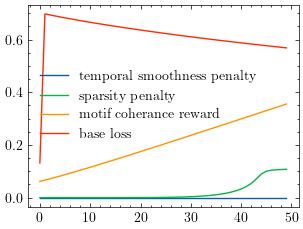

In [ ]:
with plt.style.context('science'): 
    for m, l in explainer.algorithm.epoch_metrics.items():
        y = [ll.detach().numpy() for ll in l]
        plt.plot(y)
        # plt.scatter((range(len(y))), y, s=0.4)
        
    plt.legend(explainer.algorithm.epoch_metrics.keys())
    plt.show()

### Performance

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:12<00:00,  8.04s/it]


fid+ : 0.0513	fid- : 0.0207

Class                fid+      fid-      char
Benign              0.020     0.001     0.027
DDoS                0.046     0.019     0.396
DoS                 0.036     0.019     0.346
Reconnaissance      0.003     0.001     0.040
Theft               0.001     0.000     0.034


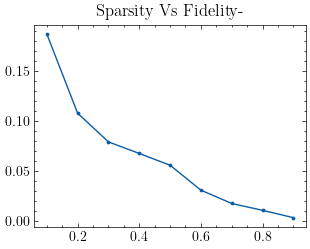

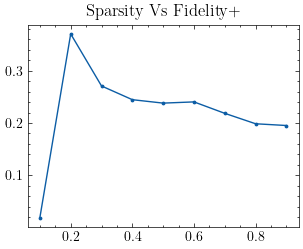

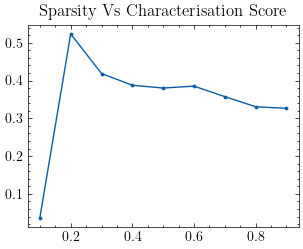

In [ ]:
import copy
from torch_geometric.explain.metric import fidelity, characterization_score

metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}

explanation_cp = copy.deepcopy(explanation)

for s in tqdm(np.arange(0.1, 1, 0.1)):
    flat_mask = explanation.node_mask.flatten()
    k = int(s * flat_mask.numel())
    threshold = torch.topk(flat_mask, k).values[-1]
    
    new_mask = (explanation.node_mask >= threshold).float()
    explanation_cp.node_mask = new_mask
    
    fp, fn = fidelity(explainer, explanation_cp)
    metrics['fid+'].append(fp)
    metrics['fid-'].append(fn)
    
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    metrics['c'].append(c)
    metrics['s'].append(s)
    metrics['k'].append(k)
    
metrics['softmask fidelity'] = fidelity(explainer, explanation)

ym_pred = explainer.get_masked_prediction(G.x[:, :49], G.edge_index, explanation.node_mask).argmax(axis=1)
ymi_pred = explainer.get_masked_prediction(G.x[:, :49], G.edge_index, 1-explanation.node_mask).argmax(axis=1)
y_pred = explainer.get_masked_prediction(G.x[:, :49], G.edge_index, torch.ones_like(explanation.node_mask)).argmax(axis=1)

for idx in range(5):
    attack = encoders['Attack'].inverse_transform([idx])[0]
    fp, fn = fidelities(y_pred= y_pred == idx, 
                        y_mask= ym_pred == idx, 
                        y_imask= ymi_pred == idx,
                        y= G.Attack==idx)

    w = (G.Attack==idx).float().mean()
    c = characterization_score(fp, fn, 
                               pos_weight=w, 
                               neg_weight=1-w) if fp*fn > 0 else 0
    
    metrics[f'softmask fidelity {attack}'] = fp, fn, c
    
view_metrics([metrics])

fid+ : 0.0551	fid- : 0.0219

Class                fid+      fid-      char
Benign              0.032     0.002     0.042
DDoS                0.051     0.020     0.421
DoS                 0.032     0.020     0.317
Reconnaissance      0.003     0.001     0.036
Theft               0.003     0.000     0.099


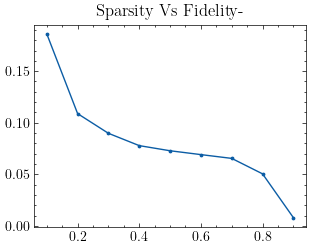

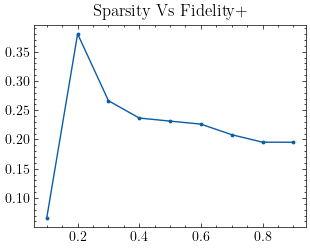

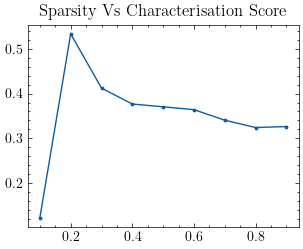

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:11<00:00,  7.98s/it]


fid+ : 0.0519	fid- : 0.0213

Class                fid+      fid-      char
Benign              0.018     0.001     0.024
DDoS                0.047     0.020     0.400
DoS                 0.039     0.020     0.364
Reconnaissance      0.003     0.001     0.035
Theft               0.001     0.000     0.030


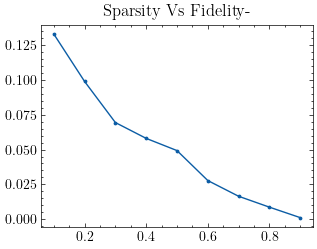

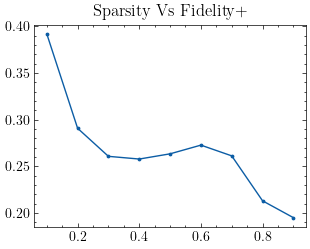

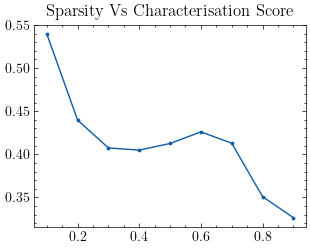

In [ ]:
import copy
from torch_geometric.explain.metric import fidelity, characterization_score

metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}

explanation_cp = copy.deepcopy(explanation)

for s in tqdm(np.arange(0.1, 1, 0.1)):
    flat_mask = explanation.node_mask.flatten()
    k = int(s * flat_mask.numel())
    threshold = torch.topk(flat_mask, k).values[-1]
    
    new_mask = (explanation.node_mask >= threshold).float()
    explanation_cp.node_mask = new_mask
    
    fp, fn = fidelity(explainer, explanation_cp)
    metrics['fid+'].append(fp)
    metrics['fid-'].append(fn)
    
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    metrics['c'].append(c)
    metrics['s'].append(s)
    metrics['k'].append(k)
    
    
metrics['softmask fidelity'] = fidelity(explainer, explanation)

ym_pred = explainer.get_masked_prediction(G.x[:, :49], G.edge_index, explanation.node_mask).argmax(axis=1)
ymi_pred = explainer.get_masked_prediction(G.x[:, :49], G.edge_index, 1-explanation.node_mask).argmax(axis=1)
y_pred = explainer.get_masked_prediction(G.x[:, :49], G.edge_index, torch.ones_like(explanation.node_mask)).argmax(axis=1)

for idx in range(5):
    attack = encoders['Attack'].inverse_transform([idx])[0]
    fp, fn = fidelities(y_pred= y_pred == idx, 
                        y_mask= ym_pred == idx, 
                        y_imask= ymi_pred == idx,
                        y= G.Attack==idx)

    w = (G.Attack==idx).float().mean()
    c = characterization_score(fp, fn, 
                               pos_weight=w, 
                               neg_weight=1-w) if fp*fn > 0 else 0
    
    metrics[f'softmask fidelity {attack}'] = fp, fn, c
     
view_metrics([metrics])